In [1]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import scipy
import numpy as np
import copy
import spectral
import pickle

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2
from hsiViewer import hsi_viewer_ROI as hvr

# set the directory where data will be downloaded and accessed
# (This directory will be saved in a config file and used each time you use hyperspectral_gta_data, 
# so you don't need to run the 'set_data_dir' function every time you use hyperspectral_gta_data.)
hsi_data.set_data_dir('C:/spectral_data')

In [26]:
# Helper functions

def add_white(im, tgt_spectra):
    im.t = tgt_spectra
    
    # Compute the mean and covariance
    im.mu = np.mean(im.dataList, axis=0)
    #im.mu = np.reshape(imageMean, (len(imageMean),1))
    im.C = np.cov(im.dataList.T)
    
    # Compute the eigenvectors, eigenvalues, and whitening matrix
    evals,evecs = np.linalg.eig(im.C)
    # truncate the small eigenvalues to stablize the inverse
    evals[evals<10**(-8)] = 10**(-8)
    DiagMatrix = np.diag(evals**(-1/2))
    im.W = np.matmul(evecs,DiagMatrix)
    
    # Whiten the image
    im_demean = im.List-im.mu
    im.ListW = np.matmul(im.W.T,im_demean.T).T 
    
    # Whiten the target
    im.tW = np.matmul(im.W.T,(im.t-im.mu).T).T
    
    return im

def ace_det(im):            
    nr = im.nrows # number of rows in the image
    nc = im.ncols # number of columns in the image
    nt = im.tW.shape[0] # number of target spectra
    # numerator is dot product of each pixel and the target (whitened)
    numerator = np.matmul(im.ListW,im.tW.T) #XT
    # denomenator is norm of each pixel times the norm of the target (whitened)
    Xnorm = np.reshape(np.sqrt(np.sum(im.ListW**2, axis=1)), (nr*nc,1))
    Tnorm = np.reshape(np.sqrt(np.sum(im.tW**2, axis=1)), (nt,1))
    denom = np.matmul( Xnorm, Tnorm.T) #sqrt(XX)*sqrt(TT)
    # take the ratio and reshape
    D = numerator / denom # XT/(sqrt(XX)*sqrt(TT))
    D = np.reshape(D, (nr, nc, nt))
    return D  

def mf_det(im):
    nr = im.nrows # number of rows in the image
    nc = im.ncols # number of columns in the image
    nt = im.tW.shape[0] # number of target spectra
    # numerator is dot product of each pixel and the target (whitened)
    numerator = np.matmul(im.ListW,im.tW.T) #XT
    # denomenator is the norm of the target squared (whitened)
    denom = np.reshape(np.sum(im.ListW**2, axis=1), (nr*nc,1)) #XX
    # take the ratio and reshape
    D = numerator / denom #XT/XX
    D = np.reshape(D, (nr, nc, nt))
    return D 


def plot_hist(det, roiData, nbins=50, detectorName='ACE'):
    
    # calculate the masks
    states_Bacc = np.squeeze(roiData.masks['Baccharis Halimifolia']).astype(int)

    # calculate output probabilities    
    Bacc_det = det[states_Bacc==1]
    Bacc_mean = np.mean(Bacc_det)
    Bacc_std = np.std(Bacc_det)

    N_det = det[states_Bacc==0]
    N_mean = np.mean(N_det)
    N_std = np.std(N_det)

    print(f'Bacc: mean={Bacc_mean}, std={Bacc_std}')
    print(f'None: mean={N_mean}, std={N_std}')

    # plot output pdfs

    # plot historgrams of the output
    plt.figure(figsize=(12,4))
    plt.subplot(1, 3, 1) # layout to make 1 row, 2 columns of plots, and create to location 1.
    ax1 = sns.histplot(data=N_det, stat="probability", bins=nbins, kde=True, label=f'{detectorName} None');
    ax1 = sns.histplot(data=Bacc_det, stat="probability", bins=nbins, kde=True, label=f'{detectorName} Baccharis');
    ax1.set(xlabel='x ', ylabel='Frequency', title='Observation Histograms')
    ax1.legend();

    # plot the probability density functions
    ax2 = plt.subplot(1, 3, 2) # layout to make 1 row, 2 columns of plots, and create to location 2.
    x = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100) # generate a list of x-values
    yn = scipy.stats.norm.pdf(x, loc=N_mean, scale=N_std) # compute the PDF at these x-values
    ax2.plot(x,yn, label='Obs None')
    yBacc = scipy.stats.norm.pdf(x, loc=Bacc_mean, scale=Bacc_std) # compute the PDF at these x-values
    ax2.plot(x,yBacc, label='Obs Baccharis')
    ax2.legend()
    ax2.set(xlabel='x ', ylabel='PDF', 
        title=f'Observation PDFs');

    # plot the cumulative density functions
    ax3 = plt.subplot(1, 3, 3) # layout to make 1 row, 2 columns of plots, and create to location 2.
    ax3.plot(x,yBacc/(yBacc+yn), label='Obs Bacc')
    ax3.legend()
    ax3.set(xlabel='x ', ylabel='CDF', 
        title=f'Detection CDF');
    plt.tight_layout()


# 1. Download the data

In [3]:
# Here are the datasets available through the hyperspectral_gta_data package
hsi_data.available_datasets()

Available Images:
   WashingtonDC
   MicroscenePolymers
   DetectionImagery_CookeCity_RIT
   VegBaccharisUPWINS
   PaintDetectionUPWINS
   indian_pines
   pavia_centre
   pavia_university
   AVIRIS_Cuprite
   ENMAP_Cuprite
Available Spectral Libraries:
   GHISACONUS_2008_001_speclib
   Microscene_Polymers_Library
   UPWINS_4_16_2024
   Detection_Library_Cooke_City_RIT
   USGS_splib07b


## Download the hyperspectral image

In [4]:
# Download and use the Cooke Cite image:
hsi_data.download('VegBaccharisUPWINS')
fname = hsi_data.get_fname('VegBaccharisUPWINS')

Available Files:
C:\spectral_data\spectral_images\Vegetation_Baccharis_halmifolia_UPWINS\Morven_Baccharis_h_or_ref
C:\spectral_data\spectral_images\Vegetation_Baccharis_halmifolia_UPWINS\Morven_Baccharis_h_or_ref.hdr
Primary Image Filename:
C:/spectral_data\spectral_images\Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref


In [5]:
# load the Cooke City hyperspectral iamge
fname = 'C:/spectral_data\spectral_images\Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref'
fname_hdr = 'C:/spectral_data\spectral_images\Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref.hdr'

# Open the image and read into an array
im = spectral.envi.open(fname_hdr, fname)
wl_im = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
imArr = im.Arr
mask = np.sum(im.Arr, axis=2)>0
print(f'Shape of ImArr = {im.Arr.shape}')
im.List = np.reshape(im.Arr, (im.nrows*im.ncols, im.nbands))
im.ListMask = np.reshape(mask, (im.nrows*im.ncols))
print(f'Shape of imList = {im.List.shape}')
im.dataList = im.List[im.ListMask==1,:]

Shape of ImArr = (300, 600, 343)
Shape of imList = (180000, 343)


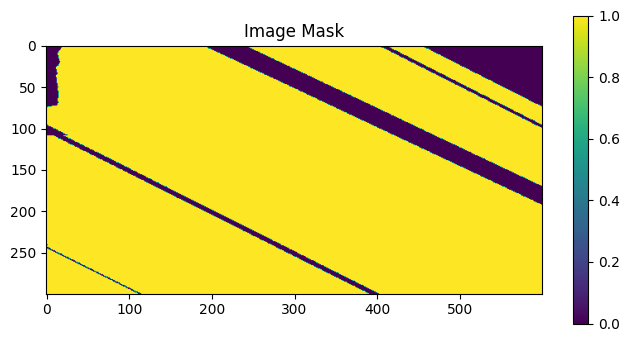

In [6]:
plt.figure(figsize=(8,4))
plt.imshow(mask)
plt.colorbar()
plt.title('Image Mask');

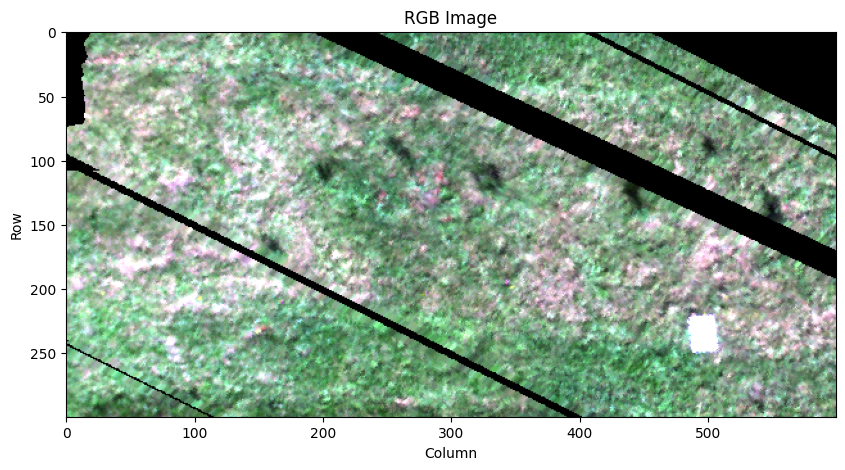

In [7]:
# display the image
sm2.display_RGB(im.Arr, wl_im, rotate=False)
plt.title('RGB Image');

# Load ROI Ground Truth


In [8]:
fname = 'C:/spectral_data/spectral_images/UPWINS Baccharis Halimifolia.pkl'
with open(fname, 'rb') as f:
    roiData = pickle.load(f)

### Examine some of the information in the roiData ground truth dictionary

In [9]:
roiData.names

['Baccharis Halimifolia',
 'Flag',
 'Ribbon',
 'Background Healthy',
 'Background Scenesced']

In [10]:
roiData.colors['Baccharis Halimifolia']

'#fa3232'

In [11]:
roiData.masks['Baccharis Halimifolia']

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

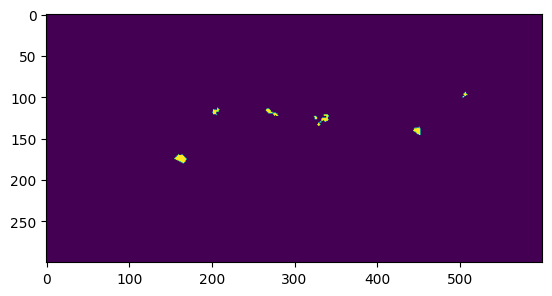

In [12]:
plt.imshow(np.squeeze(roiData.masks['Baccharis Halimifolia']).astype(int))

In [13]:
roiData.df

,Name,Color,Pixel_x,Pixel_y,399.096008,400.854004,402.612,404.369995,406.127991,407.885986,...,984.531006,986.289001,988.047974,989.80603,991.564026,993.322021,995.080017,996.838013,998.596008,1000.349976
0,Baccharis Halimifolia,#fa3232,175,155,0.0282,0.0368,0.0366,0.0344,0.0230,0.0356,...,0.4109,0.3889,0.4285,0.3314,0.3840,0.3716,0.3766,0.3416,0.3801,0.3947
1,Baccharis Halimifolia,#fa3232,174,156,0.0282,0.0368,0.0366,0.0344,0.0230,0.0356,...,0.4109,0.3889,0.4285,0.3314,0.3840,0.3716,0.3766,0.3416,0.3801,0.3947
2,Baccharis Halimifolia,#fa3232,175,156,0.0334,0.0369,0.0309,0.0318,0.0287,0.0324,...,0.4090,0.3906,0.4206,0.3356,0.3441,0.3810,0.3301,0.3485,0.3527,0.3558
3,Baccharis Halimifolia,#fa3232,173,157,0.0282,0.0368,0.0366,0.0344,0.0230,0.0356,...,0.4109,0.3889,0.4285,0.3314,0.3840,0.3716,0.3766,0.3416,0.3801,0.3947
4,Baccharis Halimifolia,#fa3232,174,157,0.0332,0.0369,0.0311,0.0319,0.0285,0.0325,...,0.4091,0.3905,0.4209,0.3354,0.3456,0.3806,0.3319,0.3482,0.3538,0.3573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,Background Scenesced,#baae80,108,172,0.0547,0.0529,0.0493,0.0510,0.0494,0.0515,...,0.3388,0.3305,0.3511,0.3505,0.3243,0.3076,0.3674,0.3502,0.3996,0.3676
250,Background Scenesced,#baae80,104,173,0.0451,0.0459,0.0377,0.0331,0.0342,0.0394,...,0.3737,0.2927,0.3801,0.3776,0.3098,0.4160,0.2905,0.3880,0.3429,0.4168
251,Background Scenesced,#baae80,105,173,0.0460,0.0515,0.0426,0.0450,0.0347,0.0380,...,0.3536,0.3609,0.3262,0.2731,0.3314,0.3233,0.3458,0.3880,0.3494,0.4168
252,Background Scenesced,#baae80,106,173,0.0425,0.0466,0.0452,0.0468,0.0481,0.0403,...,0.2934,0.3556,0.2697,0.3226,0.3806,0.3279,0.3358,0.3361,0.3974,0.2698


# Load Spectral Library

In [14]:
# To download and use the Cooke City spectral library image:
hsi_data.download('UPWINS_4_16_2024')
fname = hsi_data.get_fname('UPWINS_4_16_2024')

Available Files:
C:\spectral_data\spectral_libraries\UPWINS_4_16_2024\UPWINS_4_16_2024.hdr
C:\spectral_data\spectral_libraries\UPWINS_4_16_2024\UPWINS_4_16_2024.sli
Primary Image Filename:
C:/spectral_data\spectral_libraries\UPWINS_4_16_2024/UPWINS_4_16_2024.sli


In [15]:
fname = 'C:/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.sli'
fname_hdr = 'C:/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.hdr'

# Open the image and read into an array
lib = spectral.envi.open(fname_hdr, fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
names = lib.names
spectra = lib.spectra
wl_lib = np.asarray(lib.bands.centers)

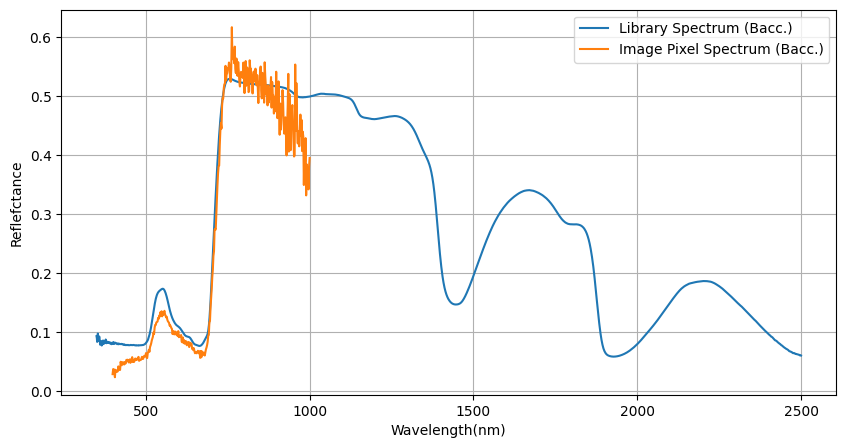

In [16]:
# Plot an image pixel spectrum and a library spectrum for comparison
plt.figure(figsize=(10,5))
plt.plot(wl_lib, spectra[0,:], label='Library Spectrum (Bacc.)')
plt.plot(wl_im, imArr[175,155,:].flatten(), label='Image Pixel Spectrum (Bacc.)')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Reflefctance');

Observations:
1. The image and library are both in nanometers, so we don't need to rescale the wavelengths
2. We need to resample the image spectrum to match the library.
3. The image seems much noiser than the library, especially for wavelengths above 750nm.  Hmmm....

In [17]:
resampler = spectral.BandResampler(wl_lib, wl_im)
spectra = resampler(lib.spectra.T).T
wl = wl_im

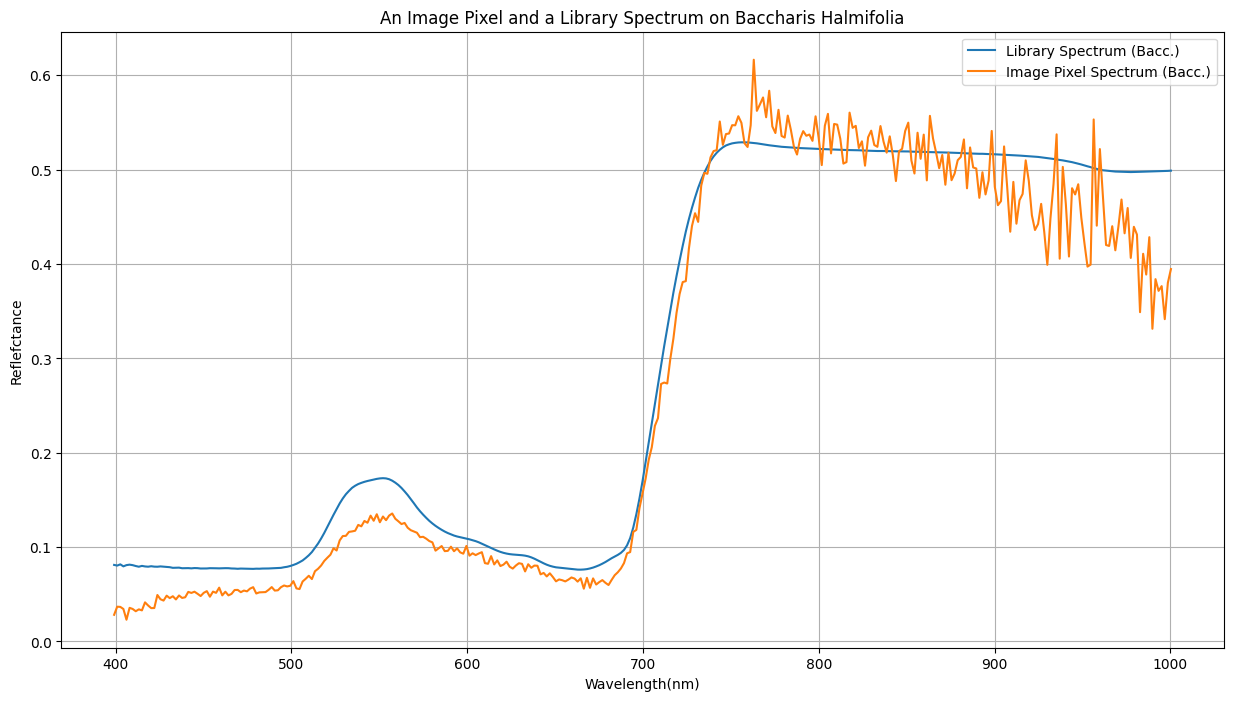

In [18]:
# Plot an image pixel spectrum and a library spectrum for comparison
plt.figure(figsize=(15,8))
plt.plot(wl, spectra[0,:], label='Library Spectrum (Bacc.)')
plt.plot(wl, imArr[175,155,:].flatten(), label='Image Pixel Spectrum (Bacc.)')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Reflefctance')
plt.title('An Image Pixel and a Library Spectrum on Baccharis Halmifolia');

# Exploritory Data Analysis on Spectral Library

In [19]:
# print the names of the library spectra, but replace the newline in the print with ' | ' to keep this on one line for nice viewing.
for n in names:
    print(n,end=' | ')

Baccharis_Halimif_L_Y1G_H00000 | Baccharis_Halimif_L_Y1G_H00001 | Baccharis_Halimif_L_Y1G_H00002 | Baccharis_Halimif_L_Y1G_H00003 | Baccharis_Halimif_L_Y1G_H00004 | Baccharis_Halimif_L_Y1G_H00005 | Baccharis_Halimif_L_Y1G_H00006 | Baccharis_Halimif_L_Y1G_H00007 | Baccharis_Halimif_L_Y1G_H00008 | Baccharis_Halimif_L_Y1G_H00009 | Baccharis_Halimif_L_Y1G_H00010 | Baccharis_Halimif_L_Y1G_H00011 | Baccharis_Halimif_L_Y1G_H00012 | Baccharis_Halimif_L_Y1G_H00013 | Baccharis_Halimif_L_Y1G_H00014 | Baccharis_Halimif_L_Y1G_H00015 | Baccharis_Halimif_L_Y1G_H00016 | Baccharis_Halimif_L_Y1G_H00017 | Baccharis_Halimif_L_Y1G_H00018 | Baccharis_Halimif_L_Y1G_H00019 | Baccharis_Halimif_L_Y1G_H00020 | Baccharis_Halimif_RS_Y1G_H00000 | Baccharis_Halimif_RS_Y1G_H00001 | Baccharis_Halimif_RS_Y1G_H00002 | Baccharis_Halimif_SA_Y1G_H00000 | Baccharis_Halimif_SA_Y1G_H00001 | Baccharis_Halimif_SA_Y1G_H00002 | Baccharis_halimifoli_L_RE_H00000 | Baccharis_halimifoli_L_RE_H00001 | Baccharis_halimifoli_L_RE_H00002 

In [20]:
tgt_indices = []
tgt_names = []
for i in range(len(names)):
    if names[i][:4]=='Bacc':
        tgt_indices.append(i)
        tgt_names.append(names[i])

spec = spectra[tgt_indices,:]
print(f'There are {len(tgt_indices)} target spectra:')
for n in tgt_names:
    print(n,end=' | ')

There are 31 target spectra:
Baccharis_Halimif_L_Y1G_H00000 | Baccharis_Halimif_L_Y1G_H00001 | Baccharis_Halimif_L_Y1G_H00002 | Baccharis_Halimif_L_Y1G_H00003 | Baccharis_Halimif_L_Y1G_H00004 | Baccharis_Halimif_L_Y1G_H00005 | Baccharis_Halimif_L_Y1G_H00006 | Baccharis_Halimif_L_Y1G_H00007 | Baccharis_Halimif_L_Y1G_H00008 | Baccharis_Halimif_L_Y1G_H00009 | Baccharis_Halimif_L_Y1G_H00010 | Baccharis_Halimif_L_Y1G_H00011 | Baccharis_Halimif_L_Y1G_H00012 | Baccharis_Halimif_L_Y1G_H00013 | Baccharis_Halimif_L_Y1G_H00014 | Baccharis_Halimif_L_Y1G_H00015 | Baccharis_Halimif_L_Y1G_H00016 | Baccharis_Halimif_L_Y1G_H00017 | Baccharis_Halimif_L_Y1G_H00018 | Baccharis_Halimif_L_Y1G_H00019 | Baccharis_Halimif_L_Y1G_H00020 | Baccharis_Halimif_RS_Y1G_H00000 | Baccharis_Halimif_RS_Y1G_H00001 | Baccharis_Halimif_RS_Y1G_H00002 | Baccharis_Halimif_SA_Y1G_H00000 | Baccharis_Halimif_SA_Y1G_H00001 | Baccharis_Halimif_SA_Y1G_H00002 | Baccharis_halimifoli_L_RE_H00000 | Baccharis_halimifoli_L_RE_H00001 | Bacc

In [21]:
tnames_short = []
for n in tgt_names:
    tnames_short.append(n.replace("Baccharis", "Bacc").replace("halimifoli", "h").replace("Halimif", "h").replace("000", ""))

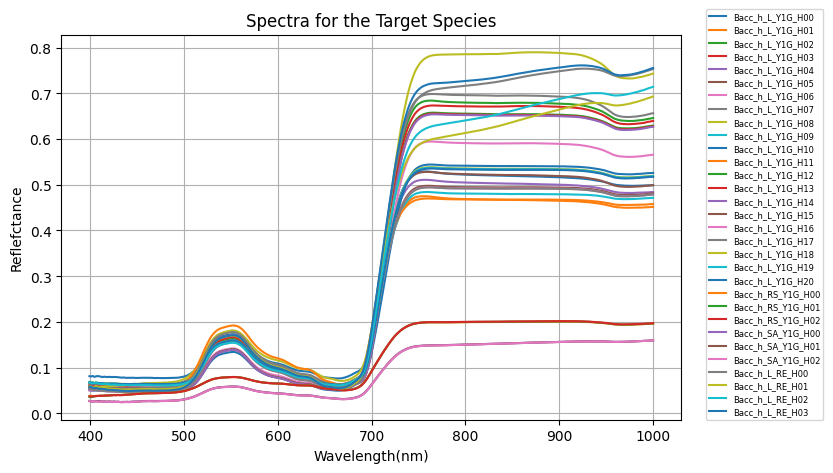

In [23]:
plt.figure(figsize=(8,5))
for i in tgt_indices:
    plt.plot(wl, spec[i,:], label=tnames_short[i]);
plt.legend(loc=(1.04,0), fontsize=6);
plt.grid(True)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Reflefctance')
plt.title('Spectra for the Target Species');

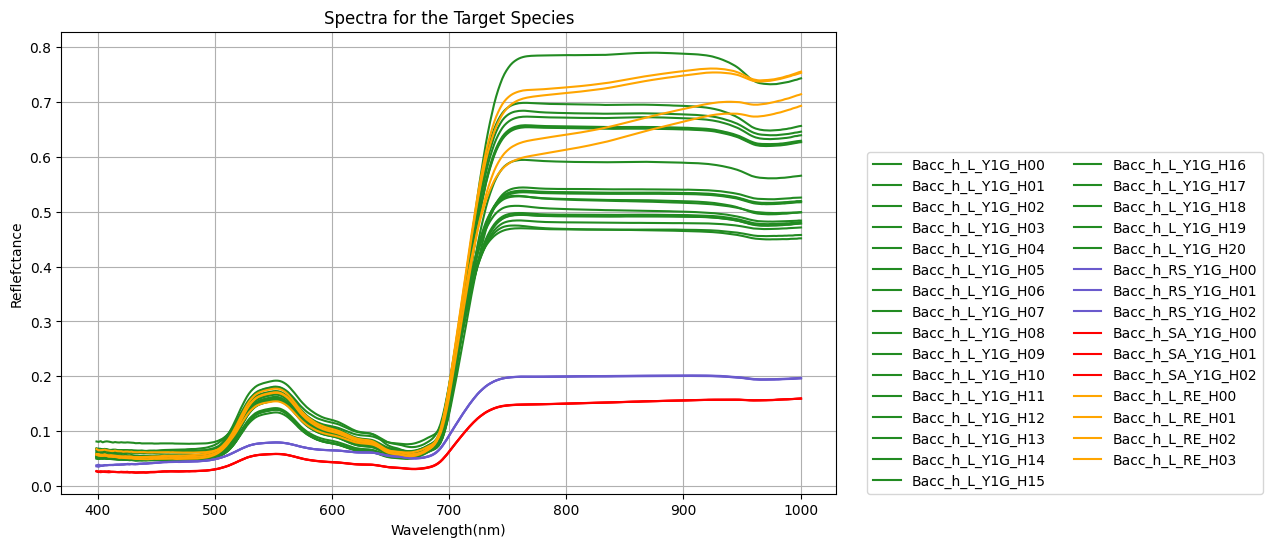

In [24]:
plt.figure(figsize=(10,6))
for i in tgt_indices:
    if '_RE_' in tnames_short[i]:
        plt.plot(wl, spec[i,:], label=tnames_short[i], c='orange');
    elif '_L_' in tnames_short[i]:
        plt.plot(wl, spec[i,:], label=tnames_short[i], c='forestgreen');
    elif '_RS_' in tnames_short[i]:
        plt.plot(wl, spec[i,:], label=tnames_short[i], c='slateblue');
    elif '_SA_' in tnames_short[i]:
        plt.plot(wl, spec[i,:], label=tnames_short[i], c='red');
plt.legend(loc=(1.04,0), fontsize=10, ncols=2);
plt.grid(True)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Reflefctance')
plt.title('Spectra for the Target Species');

Observation:
1. There seems to be 4 groups of spectra here, RE=Re-Emergence, SA=?, RS=?, and L=Leaf

# Test Target Detection

In [27]:
im = add_white(im, spec)

In [28]:
ace = ace_det(im)
ace_max_val = np.max(ace, axis=2)
mf = mf_det(im)
mf_max_val = np.max(mf, axis=2)

Bacc: mean=0.2005103337544067, std=0.06926154917022419
None: mean=0.13227152068523482, std=0.2394722866570199


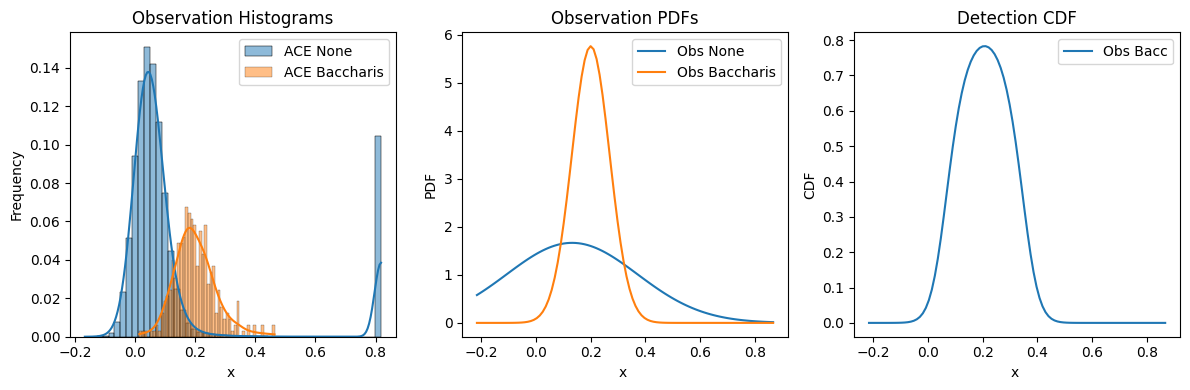

In [29]:
plot_hist(ace_max_val, roiData, detectorName='ACE')

Bacc: mean=0.21035101829158323, std=0.13839295200366739
None: mean=0.09494597496133433, std=0.16029413255201796


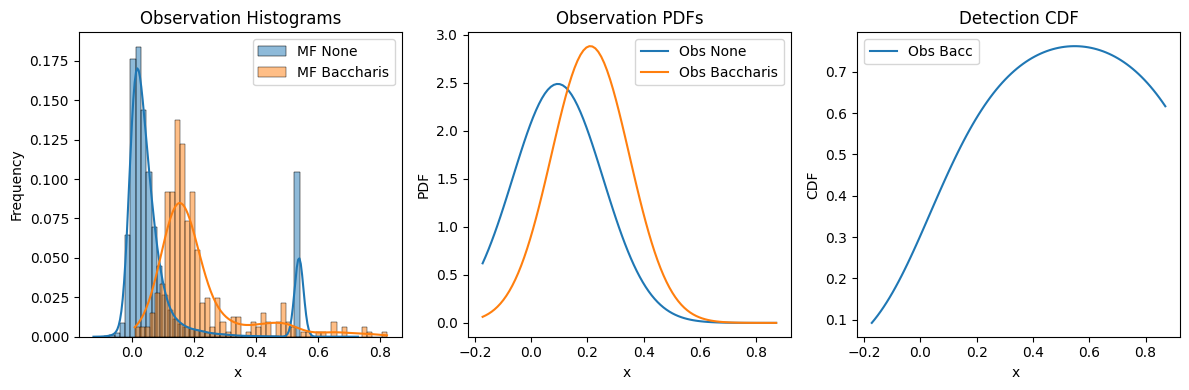

In [30]:
plot_hist(mf_max_val, roiData, detectorName='MF')

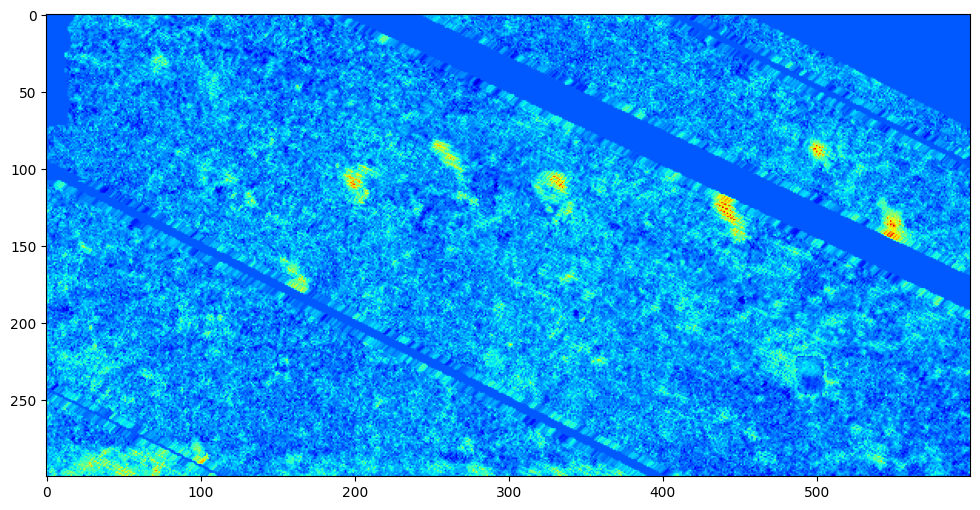

In [36]:
plt.figure(figsize=(12,6))
plt.imshow(ace_max_val*mask, cmap='jet')

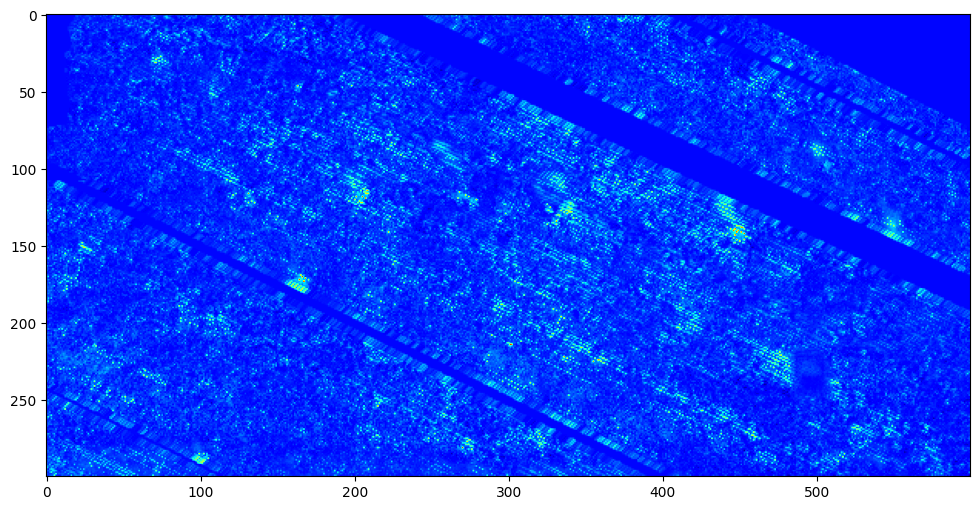

In [37]:
plt.figure(figsize=(12,6))
plt.imshow(mf_max_val*mask, cmap='jet')